In [1]:
!pip install transformers

     |████████████████████████████████| 4.2 MB 4.0 MB/s 
     |████████████████████████████████| 84 kB 3.8 MB/s 
     |████████████████████████████████| 596 kB 73.5 MB/s 
     |████████████████████████████████| 6.6 MB 47.3 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
!pip3 install torch==1.8.2+cu111 torchvision==0.9.2+cu111 torchaudio==0.8.2 -f https://download.pytorch.org/whl/lts/1.8/torch_lts.html

Looking in links: https://download.pytorch.org/whl/lts/1.8/torch_lts.html
     |█████████████▌                  | 834.1 MB 1.8 MB/s eta 0:10:52tcmalloc: large alloc 1147494400 bytes == 0x3dc2000 @  0x7f5f23e2c615 0x592b76 0x4df71e 0x59afff 0x515655 0x549576 0x593fce 0x548ae9 0x51566f 0x549576 0x593fce 0x548ae9 0x5127f1 0x598e3b 0x511f68 0x598e3b 0x511f68 0x598e3b 0x511f68 0x4bc98a 0x532e76 0x594b72 0x515600 0x549576 0x593fce 0x548ae9 0x5127f1 0x549576 0x593fce 0x5118f8 0x593dd7
     |█████████████████               | 1055.7 MB 1.2 MB/s eta 0:12:29tcmalloc: large alloc 1434370048 bytes == 0x48418000 @  0x7f5f23e2c615 0x592b76 0x4df71e 0x59afff 0x515655 0x549576 0x593fce 0x548ae9 0x51566f 0x549576 0x593fce 0x548ae9 0x5127f1 0x598e3b 0x511f68 0x598e3b 0x511f68 0x598e3b 0x511f68 0x4bc98a 0x532e76 0x594b72 0x515600 0x549576 0x593fce 0x548ae9 0x5127f1 0x549576 0x593fce 0x5118f8 0x593dd7
     |█████████████████████▋          | 1336.2 MB 1.4 MB/s eta 0:07:33tcmalloc: large alloc 1792966656 byt

In [3]:
import torch
import numpy as np 
import pandas as pd
from transformers import BertTokenizer, BertModel
import torch.nn as nn 
import torch.nn.functional as F 
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

In [4]:
df = pd.read_csv("bbc-text.csv")
df.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


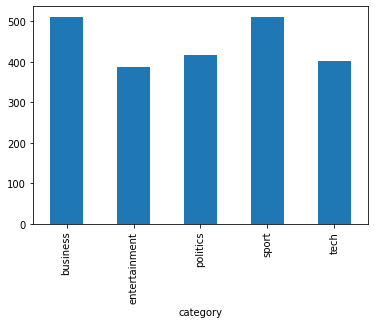

In [5]:
df.groupby(['category']).size().plot.bar()

In [6]:
tokenizer = BertTokenizer.from_pretrained("bert-base-cased")
labels = {'business':0,
          'entertainment':1,
          'sport':2,
          'tech':3,
          'politics':4}

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [7]:
class CustomDataset(Dataset):
  def __init__(self, df):
    self.labels = [labels[label] for label in df['category']]
    self.texts = [tokenizer(text, padding = "max_length", max_length = 512, truncation = True, return_tensors = "pt")
                  for text in df['text']]
  
  def classes(self):
    return self.labels
  
  def __len__(self):
    return len(self.labels)
  
  def get_batch_labels(self, idx):
    return self.labels[idx]
  
  def get_batch_texts(self, idx):
    return self.texts[idx]

  def __getitem__(self, idx):
    batch_texts = self.get_batch_texts(idx)
    batch_labels = self.get_batch_labels(idx)
    return batch_texts, batch_labels

In [8]:
class BertClassifier(nn.Module):
  def __init__(self, dropout):
    super(BertClassifier, self).__init__()
    self.bert = BertModel.from_pretrained("bert-base-cased")
    self.dropout = nn.Dropout(dropout)
    self.linear = nn.Linear(768, 5)
    self.relu = nn.Softmax()
  
  def forward(self, input_id, mask):
    _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
    dropout_output = self.dropout(pooled_output)
    linear_output = self.linear(dropout_output)
    final_layer = self.relu(linear_output)
    return final_layer

In [9]:
np.random.seed(112)
df_train, df_val, df_test = np.split(df.sample(frac=1, random_state=42), 
                                     [int(.8*len(df)), int(.9*len(df))])

print(len(df_train),len(df_val), len(df_test))

1780 222 223


In [10]:
torch.__version__

'1.8.2+cu111'

In [11]:
def train(model, train_data, val_data, learning_rate, epochs):
  train, val = CustomDataset(train_data), CustomDataset(val_data)
  train_dataloader = DataLoader(train, batch_size = 8, shuffle = True)
  val_dataloader = DataLoader(val, batch_size = 8, shuffle = True) 
  use_cuda = torch.cuda.is_available()
  device = torch.device("cuda" if use_cuda else "cpu")

  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr = learning_rate)

  if use_cuda:
    model = model.cuda()
    criterion = criterion.cuda()
  for epoch_num in range(epochs):
    total_acc_train = 0
    total_loss_train = 0 
    for train_input, train_label in tqdm(train_dataloader):
      train_label = train_label.to(device)
      mask = train_input['attention_mask'].to(device)
      input_id = train_input['input_ids'].squeeze(1).to(device)

      output = model(input_id, mask)
      batch_loss = criterion(output, train_label)
      total_loss_train += batch_loss.item()     
      acc = (output.argmax(dim=1) == train_label).sum().item()  
      total_acc_train += acc      
      model.zero_grad()
      batch_loss.backward()
      optimizer.step()

    total_acc_val = 0
    total_loss_val = 0
    with torch.no_grad():
      for val_input, val_label in tqdm(val_dataloader):
        val_label = val_label.to(device)
        mask = val_input["attention_mask"].to(device)
        input_id = val_input['input_ids'].squeeze(1).to(device)

        output = model(input_id, mask)
        batch_loss = criterion(output, val_label)
        total_loss_val += batch_loss.item()

        acc = (output.argmax(dim=1) == val_label).sum().item()
        total_acc_val += acc
    print(f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} | Train Accuracy: {total_acc_train / len(train_data): .3f} | Val Loss: {total_loss_val / len(val_data): .3f} | Val Accuracy: {total_acc_val / len(val_data): .3f}')

In [12]:
EPOCHS = 10
model = BertClassifier(0.5)
LR = 1e-6
train(model, df_train, df_val, LR, EPOCHS)

Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
  0%|          | 0/223 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Implicit dimension choice for softmax ha

Epochs: 1 | Train Loss:  0.197 | Train Accuracy:  0.302 | Val Loss:  0.192 | Val Accuracy:  0.473


100%|██████████| 28/28 [00:07<00:00,  3.66it/s]


Epochs: 2 | Train Loss:  0.186 | Train Accuracy:  0.525 | Val Loss:  0.181 | Val Accuracy:  0.662


100%|██████████| 28/28 [00:07<00:00,  3.66it/s]


Epochs: 3 | Train Loss:  0.173 | Train Accuracy:  0.720 | Val Loss:  0.162 | Val Accuracy:  0.847


100%|██████████| 28/28 [00:07<00:00,  3.66it/s]


Epochs: 4 | Train Loss:  0.153 | Train Accuracy:  0.903 | Val Loss:  0.142 | Val Accuracy:  0.977


100%|██████████| 28/28 [00:07<00:00,  3.66it/s]


Epochs: 5 | Train Loss:  0.137 | Train Accuracy:  0.967 | Val Loss:  0.132 | Val Accuracy:  0.977


100%|██████████| 28/28 [00:07<00:00,  3.66it/s]


Epochs: 6 | Train Loss:  0.128 | Train Accuracy:  0.980 | Val Loss:  0.126 | Val Accuracy:  0.986


100%|██████████| 28/28 [00:07<00:00,  3.67it/s]


Epochs: 7 | Train Loss:  0.124 | Train Accuracy:  0.983 | Val Loss:  0.123 | Val Accuracy:  0.995


100%|██████████| 28/28 [00:07<00:00,  3.66it/s]


Epochs: 8 | Train Loss:  0.121 | Train Accuracy:  0.990 | Val Loss:  0.121 | Val Accuracy:  0.991


100%|██████████| 28/28 [00:07<00:00,  3.68it/s]


Epochs: 9 | Train Loss:  0.120 | Train Accuracy:  0.991 | Val Loss:  0.120 | Val Accuracy:  0.986


100%|██████████| 28/28 [00:07<00:00,  3.66it/s]

Epochs: 10 | Train Loss:  0.118 | Train Accuracy:  0.994 | Val Loss:  0.118 | Val Accuracy:  0.995


In [13]:
def evaluate(model, test_data):
  test = CustomDataset(test_data)
  test_dataloader = DataLoader(test, batch_size = 8)
  use_cuda = torch.cuda.is_available()
  device = torch.device("cuda" if use_cuda else "cpu")

  if use_cuda:
    model = model.cuda()
  total_acc_test = 0
  with torch.no_grad():
    for test_input, test_label in tqdm(test_dataloader):
      test_label = test_label.to(device)
      mask = test_input['attention_mask'].to(device)
      input_id = test_input['input_ids'].squeeze(1).to(device)

      output = model(input_id, mask)
      acc = (output.argmax(dim=1) == test_label).sum().item()
      total_acc_test += acc
  print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')

In [14]:
evaluate(model, df_test)

  0%|          | 0/28 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  del sys.path[0]
100%|██████████| 28/28 [00:07<00:00,  3.63it/s]

Test Accuracy:  0.996


In [15]:
path='/content/saved_weights.pt'

In [ ]:
tokenizer("I love you.", padding = "max_length", max_length = 512, truncation = True, return_tensors = "pt")

In [25]:
labels_dict = ['business',
          'entertainment',
          'sport',
          'tech',
          'politics']

In [43]:
def predict_senten(sent, model):
  token = tokenizer(sent, padding = "max_length", max_length = 512, truncation = True, return_tensors = "pt");
  model = model.cuda()
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  input_id = token['input_ids'].squeeze(1).to(device)
  mask = token['attention_mask'].to(device)
  output = model(input_id, mask)
  classify = output.argmax(dim=1)
  max_ele = output.max(dim = 1)
  #print(labels_dict[classify])
  return (labels_dict[classify]), (max_ele[0].item())

In [44]:
predict_senten("Mikel Arteta's Arsenal have 'no chance' of Champions League now and I fear for them, says Jamie Carragher", model)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  del sys.path[0]


('sport', 0.6155107021331787)

In [19]:
PATH = "text_classify_bert.pth"
torch.save(model.state_dict(), PATH)

In [22]:
loaded_model = torch.load(PATH)

In [34]:
predict_senten("AI suggests how to make beer with whatever ingredients you have", model)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  del sys.path[0]


('politics',
 tensor([[0.1121, 0.1581, 0.2165, 0.1896, 0.3238]], device='cuda:0',
        grad_fn=<SoftmaxBackward>))

In [45]:
predict_senten("Invisible 3D printed tags turn simple objects into gaming controllers", model)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  del sys.path[0]


('tech', 0.34448087215423584)